In [21]:
# https://juliaoptimaltransport.github.io/OptimalTransport.jl/dev/examples/nmf/

In [4]:
using OptimalTransport
import OptimalTransport.Dual: Dual
# using MLDatasets: MLDatasets
using StatsBase
using Plots;
default(; palette=:Set1_3)
using LogExpFunctions
using NNlib: NNlib
using LinearAlgebra
using Distances
using Base.Iterators
using NMF
using Optim

In [5]:
function simplex_norm!(x; dims=1)
    return x .= x ./ sum(x; dims=dims)
end

simplex_norm! (generic function with 1 method)

In [7]:
function E_star(x; dims=1)
    return logsumexp(x; dims=dims)
end;

In [8]:
function E_star_grad(x; dims=1)
    return NNlib.softmax(x; dims=1)
end;

In [9]:
function dual_obj_weights(X, K, ε, D, G, ρ1)
    return sum(Dual.ot_entropic_semidual(X, G, ε, K)) + ρ1 * sum(E_star(-D' * G / ρ1))
end
function dual_obj_weights_grad!(∇, X, K, ε, D, G, ρ1)
    return ∇ .= Dual.ot_entropic_semidual_grad(X, G, ε, K) - D * E_star_grad(-D' * G / ρ1)
end
function dual_obj_dict(X, K, ε, Λ, G, ρ2)
    return sum(Dual.ot_entropic_semidual(X, G, ε, K)) + ρ2 * sum(E_star(-G * Λ' / ρ2))
end
function dual_obj_dict_grad!(∇, X, K, ε, Λ, G, ρ2)
    return ∇ .= Dual.ot_entropic_semidual_grad(X, G, ε, K) - E_star_grad(-G * Λ' / ρ2) * Λ
end;

In [10]:
function getprimal_weights(D, G, ρ1)
    return NNlib.softmax(-D' * G / ρ1; dims=1)
end
function getprimal_dict(Λ, G, ρ2)
    return NNlib.softmax(-G * Λ' / ρ2; dims=1)
end;

In [11]:
function solve_weights(X, K, ε, D, ρ1; alg, options)
    opt = optimize(
        g -> dual_obj_weights(X, K, ε, D, g, ρ1),
        (∇, g) -> dual_obj_weights_grad!(∇, X, K, ε, D, g, ρ1),
        zero.(X),
        alg,
        options,
    )
    return getprimal_weights(D, Optim.minimizer(opt), ρ1)
end
function solve_dict(X, K, ε, Λ, ρ2; alg, options)
    opt = optimize(
        g -> dual_obj_dict(X, K, ε, Λ, g, ρ2),
        (∇, g) -> dual_obj_dict_grad!(∇, X, K, ε, Λ, g, ρ2),
        zero.(X),
        alg,
        options,
    )
    return getprimal_dict(Λ, Optim.minimizer(opt), ρ2)
end;

In [12]:
f(x, μ, σ) = exp.(-(x .- μ) .^ 2)
coord = range(-12, 12; length=100)
N = 100
σ = 1
X = hcat(
    [
        rand() * f(coord, σ * randn() + 6, 1) +
        rand() * f(coord, σ * randn(), 1) +
        rand() * f(coord, σ * randn() - 6, 1) for _ in 1:N
    ]...,
)
X = simplex_norm!(X);

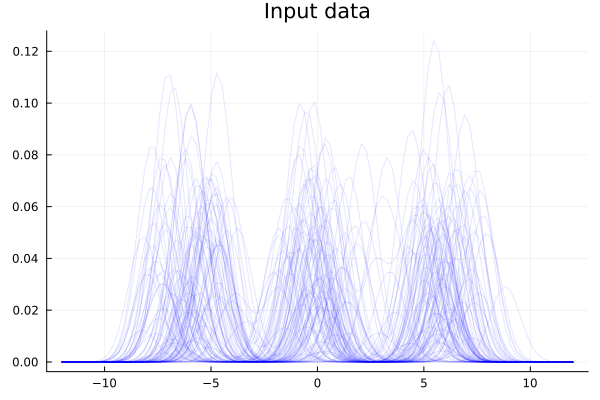

In [13]:
plot(coord, X; alpha=0.1, color=:blue, title="Input data", legend=nothing)

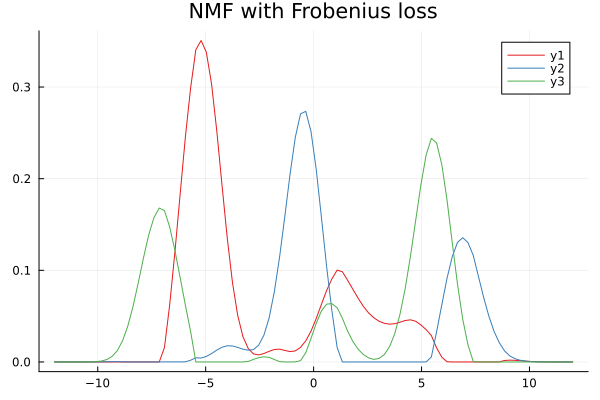

In [14]:
k = 3
result = nnmf(X, k; alg=:multmse)
plot(coord, result.W; title="NMF with Frobenius loss", palette=:Set1_3)

In [15]:
C = pairwise(SqEuclidean(), coord)
C = C / mean(C);

In [16]:
ε = 0.025
ρ1, ρ2 = (5e-2, 5e-2);

In [17]:
K = exp.(-C / ε);

In [18]:
D = rand(size(X, 1), k) # dictionary
simplex_norm!(D; dims=1) # norm columnwise
Λ = rand(k, size(X, 2)) # weights
simplex_norm!(Λ; dims=1); # norm rowwise

In [19]:
n_iter = 10
for iter in 1:n_iter
    @info "Wasserstein-NMF: iteration $iter"
    D .= solve_dict(
        X,
        K,
        ε,
        Λ,
        ρ2;
        alg=LBFGS(),
        options=Optim.Options(;
            iterations=250, g_tol=1e-4, show_trace=false, show_every=10
        ),
    )
    Λ .= solve_weights(
        X,
        K,
        ε,
        D,
        ρ1;
        alg=LBFGS(),
        options=Optim.Options(;
            iterations=250, g_tol=1e-4, show_trace=false, show_every=10
        ),
    )
end

[ Info: Wasserstein-NMF: iteration 1
[ Info: Wasserstein-NMF: iteration 2
[ Info: Wasserstein-NMF: iteration 3
[ Info: Wasserstein-NMF: iteration 4
[ Info: Wasserstein-NMF: iteration 5
[ Info: Wasserstein-NMF: iteration 6
[ Info: Wasserstein-NMF: iteration 7
[ Info: Wasserstein-NMF: iteration 8
[ Info: Wasserstein-NMF: iteration 9
[ Info: Wasserstein-NMF: iteration 10


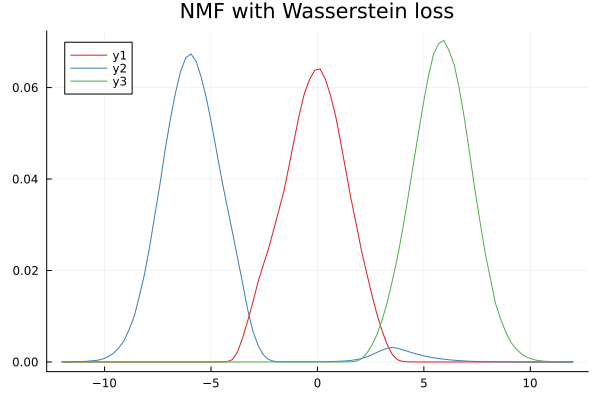

In [20]:
plot(coord, D; title="NMF with Wasserstein loss", palette=:Set1_3)